<style>
    rd { color:red; }
    bl { color:blue; }
</style>

# Feature Engineering 로 개선 가능?
## 전처리
| 작업        | 대상                                                                                       |
|:------------|:-------------------------------------------------------------------------------------------|
| 컬럼 삭제   | "RowNumber", "CustomerId", "Surname"                                                       |
| 컬럼 인코딩 | "Geography", "Gender"                                                                      |
| 컬럼 라벨링 | "CreditScore", "Geography", "Age", "Tenure", "Balance", "NumOfProducts", "EstimatedSalary" |

### 스케일링 : StandardScaler

## 하이퍼파라미터
- RandomForest
    - 순성

## 결론 :

In [28]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import seaborn           as sns

import matplotlib
import matplotlib.font_manager as fm

import re

from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.inspection import DecisionBoundaryDisplay

In [2]:
def encoding(df:pd.DataFrame, columns:list[str]):
    """범주형 데이터를 인코딩"""

    encoder_list = {}
    result_df    = df.copy(deep=True)

    for col_nm in columns:
        encoder           = LabelEncoder()
        result_df[col_nm] = encoder.fit_transform(result_df[col_nm])

        encoder_list[col_nm] = encoder

    return result_df, encoder_list


def scaling(df:pd.DataFrame, columns:list[str]):
    """DataFrame 에서 컬럼들을 스케일링"""

    scaler    = StandardScaler()
    result_df = df.copy(deep=True)

    result_df[columns] = scaler.fit_transform(result_df[columns])

    return result_df

## 데이터 로드 및 전처리

In [24]:
######################################### 데이터 로드
df     = pd.read_csv("../data/Churn_Modelling.csv")
# inputs = df.drop(columns=["Exited"], axis=1)
# labels = df["Exited"]

df = df[["IsActiveMember", "NumOfProducts", "Age", "Balance", "Gender", "Geography", "Exited"]]
df, enc = encoding(df, ["Gender", "Geography"])


stayed_df   = df[df["Exited"] == 0]
stayed_half = len(stayed_df) // 3
backup_df   = stayed_df.iloc[:stayed_half]
stayed_df   = stayed_df.iloc[stayed_half:]

exited_df   = df[df["Exited"] == 1]

target_df   = pd.concat([stayed_df, exited_df])
inputs      = target_df.drop(columns=["Exited"], axis=1)
labels      = target_df["Exited"]

# inputs = scaling(inputs, ["IsActiveMember", "NumOfProducts", "Age", "Balance"])

inputs = inputs.reset_index(drop=True)
labels = labels.reset_index(drop=True)
display(inputs.head(2))
display(labels.head(2))

####################################### 데이터 전처리
_input = inputs

backup_input = backup_df.drop(columns=["Exited"], axis=1)
backup_label = backup_df["Exited"]

backup_input = backup_input.reset_index(drop=True)
backup_label = backup_label.reset_index(drop=True)

,IsActiveMember,NumOfProducts,Age,Balance,Gender,Geography
0,1,1,74,116800.25,0,1
1,1,2,67,0.00,1,0


0    0
1    0
Name: Exited, dtype: int64

In [117]:
print(_input.info(), "\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7346 entries, 0 to 7345
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   IsActiveMember  7346 non-null   int64  
 1   NumOfProducts   7346 non-null   int64  
 2   Age             7346 non-null   int64  
 3   Balance         7346 non-null   float64
dtypes: float64(1), int64(3)
memory usage: 229.7 KB
None 



In [118]:
print(labels.value_counts(), "\n")
print(backup_label.value_counts())

Exited
0    5309
1    2037
Name: count, dtype: int64 

Exited
0    2654
Name: count, dtype: int64


## 데이터 분할

In [31]:
######################################### 데이터 분할. random_state 지정한 상태에서 성능 확인/개선해보고, state 풀었을 때도 보기.
train_x, test_x, train_y, test_y = train_test_split(_input, labels, test_size=0.2, stratify=labels)

# test_x = pd.concat([test_x, backup_input])
# test_y = pd.concat([test_y, backup_label])

print("학습 데이터 shape : ", train_x.shape, train_y.shape)
print("검증 데이터 shape : ",  test_x.shape,  test_y.shape, "\n")

학습 데이터 shape :  (5876, 6) (5876,)
검증 데이터 shape :  (1470, 6) (1470,) 



## 모델 학습 및 평가 - max_features="log2", max_depth=5
순정에 비해 정밀도는 <rd>상승</rd>, 재현율은 <bl>하락</bl>, F1점수는 <bl>하락</bl>

,fit_time,score_time,test_score,train_score
0,0.604985,0.016150,0.812245,0.845555
1,0.681136,0.015670,0.840816,0.844194
2,0.806872,0.016374,0.842177,0.845166
3,0.751465,0.019424,0.843537,0.843416
4,1.042306,0.021647,0.833787,0.853170
5,0.834539,0.020195,0.813351,0.854142
6,0.817656,0.014145,0.822888,0.850253
7,0.881713,0.020784,0.848774,0.848503


Binning 0.000 GB of training data: 0.026 s
Binning 0.000 GB of validation data: 0.000 s
Fitting gradient boosted rounds:
[1/5000] 1 tree, 25 leaves, max depth = 5, train score: 0.72277, val score: 0.72279, in 0.009s
[2/5000] 1 tree, 25 leaves, max depth = 5, train score: 0.72277, val score: 0.72279, in 0.006s
[3/5000] 1 tree, 25 leaves, max depth = 5, train score: 0.72277, val score: 0.72279, in 0.004s
[4/5000] 1 tree, 25 leaves, max depth = 5, train score: 0.72277, val score: 0.72279, in 0.006s
[5/5000] 1 tree, 26 leaves, max depth = 5, train score: 0.72277, val score: 0.72279, in 0.003s
[6/5000] 1 tree, 25 leaves, max depth = 5, train score: 0.72277, val score: 0.72279, in 0.003s
[7/5000] 1 tree, 25 leaves, max depth = 5, train score: 0.72277, val score: 0.72279, in 0.002s
[8/5000] 1 tree, 25 leaves, max depth = 5, train score: 0.72277, val score: 0.72279, in 0.004s
[9/5000] 1 tree, 25 leaves, max depth = 5, train score: 0.72277, val score: 0.72279, in 0.000s
[10/5000] 1 tree, 26 lea

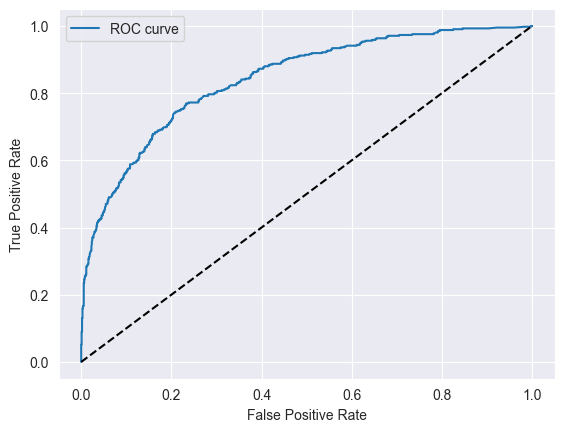

In [32]:
######################################### 모델 학습
model = HistGradientBoostingClassifier(
    max_iter=5000,
    n_iter_no_change=100,
    early_stopping=True,
    validation_fraction=0.1,
    learning_rate=0.03,
    max_depth=5,
    # loss="",
    # scoring="recall",
    scoring="accuracy",
    verbose=2
)
results = pd.DataFrame(cross_validate(model, train_x, train_y, cv=8, return_train_score=True, n_jobs=-1)).round(6)
display(results)


######################################### 모델 성능 평가
model.fit(train_x, train_y)
predicted = model.predict(test_x)
print("Threshold 조정 전")
print(classification_report(test_y, predicted, target_names=["Stayed", "Exited"]))

threshold = 0.4
pred_prob = model.predict_proba(test_x)
pred_adj  = pred_prob[:, 1]
pred_adj  = (pred_adj >= threshold).astype(int)
print(f"Threshold >= {threshold}")
print(classification_report(test_y, pred_adj, target_names=["Stayed", "Exited"]))

fprs, tprs, thresholds = roc_curve(test_y, pred_prob[:,1])
plt.plot(fprs, tprs, label='ROC curve')
plt.plot([0,1], [0,1], "k--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)

plt.show()

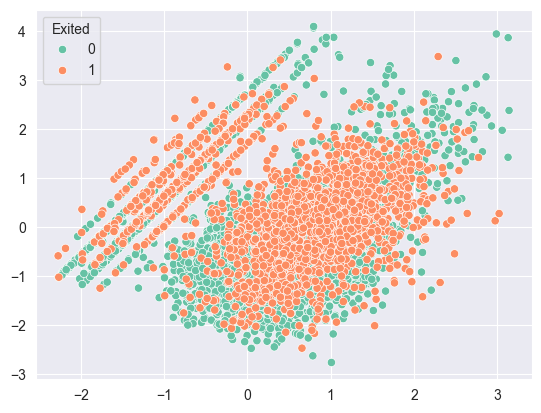

,0,1,Exited
0,2.343639,2.425787,0
1,0.113250,2.938570,0
2,1.179690,-1.421440,0


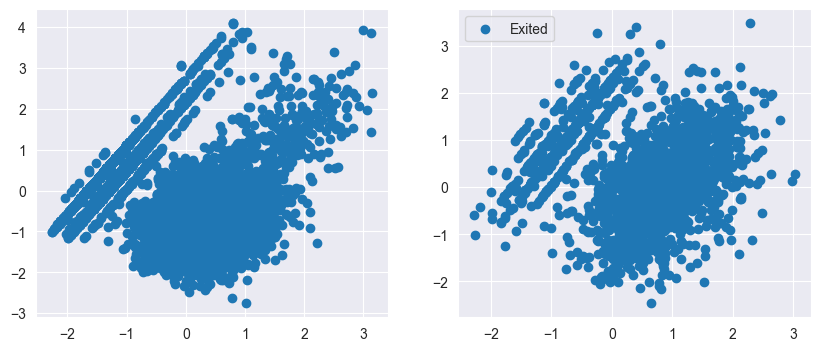

In [30]:
pca        = PCA(n_components=2)
inputs2    = scaling(inputs, ["Balance", "Age"])
# inputs2    = inputs
pca_result = pca.fit_transform(inputs2)

sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=labels, palette="Set2")
# plt.xlim(0, 1)
# plt.ylim(-1, 0)
# plt.xlim(40000, 600)
# plt.ylim(0, 10)
plt.show()

pca_result = pd.DataFrame(pca_result)
pca_result["Exited"] = labels
display(pca_result.head(3))

fix, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].scatter(x=pca_result[pca_result["Exited"] == 0][0], y=pca_result[pca_result["Exited"] == 0][1], label="Stayed")
ax[1].scatter(x=pca_result[pca_result["Exited"] == 1][0], y=pca_result[pca_result["Exited"] == 1][1], label="Exited")

plt.legend()
plt.grid(True)

plt.show()